In [1]:
# models and data processing from https://github.com/SamsungLabs/pytorch-ensembles/blob/master

import os
import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

%matplotlib inline
from IPython.display import HTML, display, set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10

import torch.nn.functional as F
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from utils import weighted_mean, weighted_sd, read_results
from torch_utils import d_LSE, BI_LSE, BI_thresh_acc_DE, BI_thresh_acc_TTA, Conf_thresh_acc

set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

ds_name = 'ImageNet-C'

/tmp/ipykernel_3973747/3642246941.py:35: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


In [2]:
prefix = '../saved_models/deepens_imagenet/ImageNet-ResNet50-{}-1.pth.tar'
suffix_list = [
    '052e7f78e4db--1564492444',
    '1132c260ef75--1564493784',
    '2f817072e8da--1564493734',
    '3177c697fbf4--1564495013',
    '628e11f9fd67--1564481099',
    '743e10f26a38--1564493675',
    '7ded66ec9900--1564481097',
    '8fc5076a66c9--1564481079',
    'a58ab8dd26fc--1564492521',
    'a80e40d84db2--1564492573',
]

In [3]:
models = []
for suffix in suffix_list:
    checkpoint = torch.load(prefix.format(suffix))
    model = torchvision.models.resnet50()
    model = torch.nn.DataParallel(model, device_ids = [0, 1, 2, 3]).cuda()
    model.load_state_dict(checkpoint['state_dict'])
    models.append(model)

In [4]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "../data/")
DATA_MEANS = (0.485, 0.456, 0.406)
DATA_STD = (0.229, 0.224, 0.225)
batch_size = 64

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD)]
)

val_dataset = torchvision.datasets.ImageNet(root=DATASET_PATH, split='val', transform=test_transform)
print(len(val_dataset))
pl.seed_everything(42)
val_set, test_set = torch.utils.data.random_split(val_dataset, [10000, 40000])

# We define a set of data loaders that we can use for various purposes later.
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4, pin_memory=True)

Global seed set to 42


50000


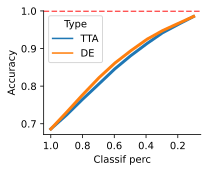

In [15]:
results_BI_TTA['Type'] = 'TTA'
results_BI_DE['Type'] = 'DE'
results = pd.concat([results_BI_TTA, results_BI_DE])
plt.rcParams.update({'font.size': 10, 'figure.dpi': 1000})
figure = plt.figure(figsize=(3, 2.5))
ax = plt.subplot(1, 1, 1)
plot = sns.lineplot(data=results, x='Classif perc', y='Accuracy', hue='Type', ax=ax, linewidth=3)
plot.invert_xaxis()
plot.axhline(1., c='red', ls='dashed')
sns.despine()
plt.tight_layout()
plt.savefig('plots/resnet_imgnet_TTAvsDE.png', bbox_inches='tight')
plt.show()

In [8]:
# ImageNet-C

def imshow(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_loader(corruption, severity = 5):
    dataset = torchvision.datasets.ImageFolder(
        root='../data/ImageNet-C/' + corruption + '/' + str(severity),
        transform=test_transform
    )
    # to avoid data leakage, we require an identical val / test set split as above
    pl.seed_everything(42)
    _, test_set = torch.utils.data.random_split(dataset, [10000, 40000])


    return torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
# checking for data leak
#imshow(test_loader)

In [149]:
# No data leak observable
#imshow(get_loader('brightness'))

In [ ]:
# this cell takes >10 hours
qs = np.arange(10, -1, -1) / 10
corruptions = [
    'None',
    'brightness',
    'fog',
    'glass_blur',
    'pixelate',
    'spatter',
    'contrast',
    'frost',
    'impulse_noise',
    'saturate',
    'speckle_noise',
    'defocus_blur',
    'gaussian_blur',
    'jpeg_compression',
    'shot_noise',
    'zoom_blur',
    'elastic_transform',
    'gaussian_noise',
    'motion_blur',
    'snow',
]
target = 'Accuracy'

for type_ in ['DE', 'TTA', 'Conf']:
    if type_=='DE':
        experiment = BI_thresh_acc_DE(models, val_loader, qs=qs, device='cuda:0')
    elif type_=='TTA':
        experiment = BI_thresh_acc_TTA(models[0], val_loader, qs=qs, n_ens=20, device='cuda:0')
    elif type_=='Conf':
        experiment = Conf_thresh_acc(models[0], qs=qs, device='cuda:0')

    for severity in tqdm(range(1, 6)):
        loaders = []
        for corr in tqdm(corruptions, leave=False):
            if corr == 'None':
                loaders += [test_loader]
            else:
                loaders += [get_loader(corr, severity=severity)]

        results_BI_ood = experiment.run(loaders)
        results_BI_ood = results_BI_ood.reset_index(drop=True)
        results_BI_ood.to_pickle('results/{}/{}/all/{}_sev{}.pkl'.format(ds_name, target, type_, severity))

Val set:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


Loader:   0%|          | 0/20 [00:00<?, ?it/s]

Test set:   0%|          | 0/625 [00:00<?, ?it/s]

Test set:   0%|          | 0/625 [00:00<?, ?it/s]

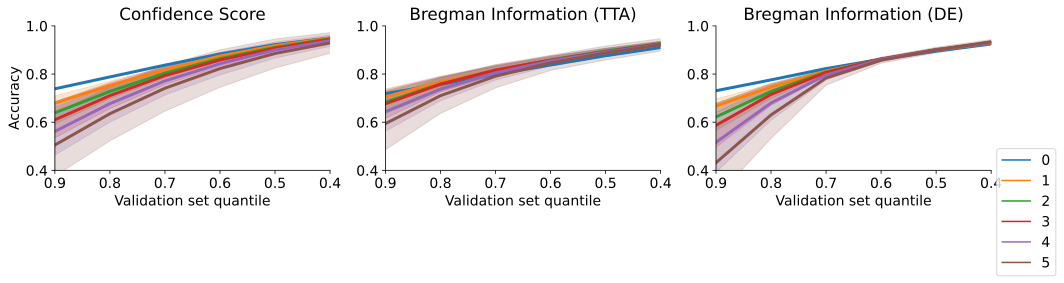

In [21]:
# Figure 7
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
target = 'Accuracy'
hue = 'Corruption Severity'

unc_type = 'Conf'
results_Conf_all = []
for severity in range(1, 6):
    results_Conf_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_Conf_all = pd.concat(results_Conf_all)

unc_type = 'DE'
results_DE_all = []
for severity in range(1, 6):
    results_DE_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_DE_all = pd.concat(results_DE_all)

unc_type = 'TTA'
results_TTA_all = []
for severity in range(1, 6):
    results_TTA_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_TTA_all = pd.concat(results_TTA_all)


plt.rcParams.update({'font.size': 14, 'figure.dpi': 1000})
figure, axs = plt.subplots(1, 3, figsize=(15, 4))

hue = 'Corruption Severity'

ax = axs[0]
plot = sns.lineplot(
    data=results_Conf_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3,
    estimator=weighted_mean, errorbar=weighted_sd, legend=False)
#plot.axhline(1., c='black', ls='dashed')
plot.invert_xaxis()
ax.set_ylim(0.4, 1.0)
ax.set_xlim(0.9, 0.4)
ax.set_title('Confidence Score')
sns.despine()

ax = axs[1]
plot = sns.lineplot(
    data=results_TTA_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd, legend=False)
plot.invert_xaxis()
#plot.axhline(1., c='black', ls='dashed')
ax.set_ylim(0.4, 1.0)
ax.set_xlim(0.9, 0.4)
ax.set_ylabel('')
ax.set_title('Bregman Information (TTA)')
sns.despine()

ax = axs[2]
plot = sns.lineplot(
    data=results_DE_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd)
plot.invert_xaxis()
#plot.axhline(1., c='black', ls='dashed')
ax.set_ylim(0.4, 1.0)
ax.set_xlim(0.9, 0.4)
ax.set_ylabel('')
ax.set_title('Bregman Information (DE)')
sns.despine()

ax.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('plots/resnet_imgnet-C_all.png', bbox_inches='tight')
plt.show();